In [108]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lng

In [109]:
def f(v, t, p, Q, A, b):
    if not (b-A.dot(v)>0).all():
        return 1e10
    return t*(v.T@Q@v + p.T@v) - np.sum(np.log(b-A@v))

In [110]:
def grad_f(v, t, p, Q, A, b):
    grad_f = t*(p + 2*Q@v)
    grad_phi = 0
    for i in range(len(b)):
        grad_phi += (1/(b[i] - A[i,:]@v))*A[i,:]
    grad_phi = np.reshape(grad_phi,grad_f.shape)
    grad_f += grad_phi
    return grad_f

In [111]:
def hess_f(v, t, p, Q, A, b):
    temp = b-A.dot(v)
    return 2*t*Q + sum([1/(temp[i])**2 * A[i,].reshape(-1,1).dot(A[i,].reshape(1,-1)) for i in range(A.shape[0])])

In [112]:
def backtracking(v, alpha, beta, delta_x, t, p, Q, A, b):
    t2 = 1
    v2 = v+t2*delta_x
    f1 = f(v+t2*delta_x, t, p, Q, A, b)
    f2 = f(v, t, p, Q, A, b) + alpha*t2*grad_f(v, t, p, Q, A, b).T@delta_x
    while f1 >= f2:
        t2 *= beta
        v2 = v+t2*delta_x
        f1 = f(v+t2*delta_x, t, p, Q, A, b)
        f2 = f(v, t, p, Q, A, b) + alpha*t2*grad_f(v, t, p, Q, A, b).T@delta_x
    return t2

In [113]:
def centering_step(Q, p, A, b, t, v0, eps):
    nt_iter = 0
    v_seq = [v0]
    delta_x = -lng.inv(hess_f(v_seq[-1], t, p, Q, A, b))@grad_f(v_seq[-1], t, p, Q, A, b)
    lambda_square = grad_f(v_seq[-1], t, p, Q, A, b).T@lng.inv(hess_f(v_seq[-1], t, p, Q, A, b))@grad_f(v_seq[-1], t, p, Q, A, b)
    while lambda_square/2 > eps:
        t2 = backtracking(v_seq[-1], .1, .6, delta_x, t, p, Q, A, b)
        v_seq.append(v_seq[-1] + t2*delta_x)
        nt_iter += 1
        delta_x = -lng.inv(hess_f(v_seq[-1], t, p, Q, A, b))@grad_f(v_seq[-1], t, p, Q, A, b)
        lambda_square = grad_f(v_seq[-1], t, p, Q, A, b).T@lng.inv(hess_f(v_seq[-1], t, p, Q, A, b))@grad_f(v_seq[-1], t, p, Q, A, b)
    return v_seq, nt_iter

In [114]:
def barr_method(Q, p, A, b, v0, eps):
    t = 1
    v_seq = [v0]
    nt_iter = [0]
    nt_seq, nt_iter_elt = centering_step(Q, p, A, b, t, v_seq[-1], eps)
    v_seq.append(nt_seq[-1])
    nt_iter.append(nt_iter_elt)
    m = b.shape[0]
    while m/t >= eps:
        t *= mu
        nt_seq, nt_iter_elt = centering_step(Q, p, A, b, t, v_seq[-1], eps)
        v_seq.append(nt_seq[-1])
        nt_iter.append(nt_iter[-1] + nt_iter_elt)
    return v_seq, nt_iter

In [115]:
n = 200
d = 20

X = np.random.random_sample(size=(n, d))

w0 = np.random.random_sample(size=(d,1))
y = X@w0 + np.random.normal(size=(n,1))

print(X.shape)
print(y.shape)

lambd = 10

Q = (1/2)*np.eye(n)
print(Q)
p = y
A = np.vstack((X.T,-X.T))
print(A[0,:].shape)
b = lambd*np.ones((2*d,1))
v0 = np.zeros((n,1))
eps = 0.000001

(200, 20)
(200, 1)
[[0.5 0.  0.  ... 0.  0.  0. ]
 [0.  0.5 0.  ... 0.  0.  0. ]
 [0.  0.  0.5 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.5 0.  0. ]
 [0.  0.  0.  ... 0.  0.5 0. ]
 [0.  0.  0.  ... 0.  0.  0.5]]
(200,)


In [116]:
fct = f(v0, 1, p, Q, A, b)
print(fct)

grad = grad_f(v0, 1, p, Q, A, b)
print(grad.shape)

hess = hess_f(v0, 1, p, Q, A, b)
print(hess.shape)

[[-92.10340372]]
(200, 1)
(200, 200)


In [117]:
v_seq_nt, nt_iter_center = centering_step(Q, p, A, b, 1, v0, eps)

In [118]:
mu = 15

v_seq, nt_iter = barr_method(Q, p, A, b, v0, eps)

print(len(v_seq))
print(nt_iter)

9
[0, 7, 15, 24, 33, 40, 47, 53, 59]


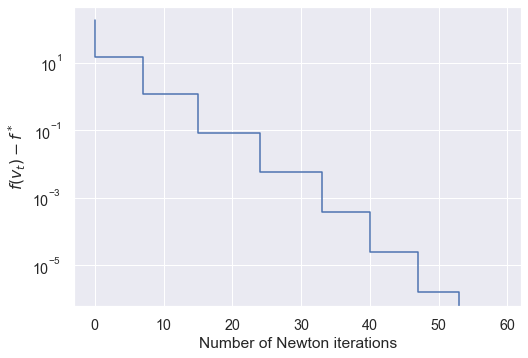

In [119]:
gap = [(v.T@Q@v + p.T.dot(v))[0,0] - (v_seq[-1].T@Q@v_seq[-1] + p.T.dot(v_seq[-1]))[0,0] for v in v_seq]

plt.step(nt_iter, gap)
plt.semilogy()
plt.xlabel('Number of Newton iterations')
plt.ylabel('$f(v_t)-f^*$')
plt.savefig("plot.eps")
plt.show()

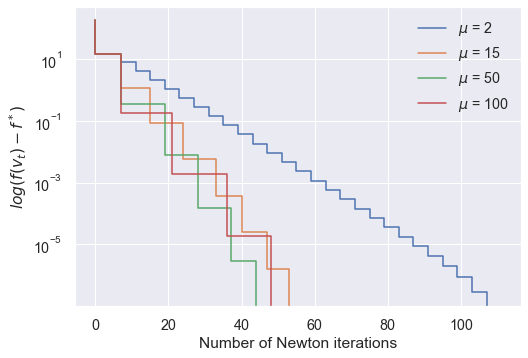

In [122]:
w_star_tab = []

for mu in [2,15,50,100]:
    v_seq, nt_iter = barr_method(Q, p, A, b, v0, eps)
    w_star_tab.append(np.reshape(np.linalg.inv(X.T@X)@X.T@(v_seq[-1] + y),d))
    gap = [(v.T@Q@v + p.T.dot(v))[0,0] - (v_seq[-1].T@Q@v_seq[-1] + p.T.dot(v_seq[-1]))[0,0] for v in v_seq]
    plt.step(nt_iter, gap, label='$\mu$ = '+str(mu))
plt.semilogy()
plt.legend(loc = 'upper right')
plt.xlabel('Number of Newton iterations')
plt.ylabel('$log(f(v_t)-f^*)$')
plt.savefig("plot.eps")
plt.show()

[]

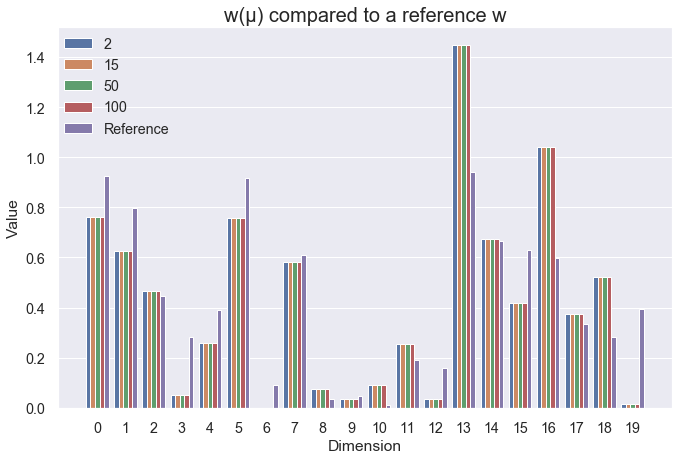

In [121]:
import pandas as pd
import seaborn as sns

plt.style.use('seaborn')

sns.set(font_scale=1.3)

mu_tab = [2,15,50,100]

dt = pd.DataFrame({mu_tab[i]:w_star_tab[i] for i in range(len(mu_tab))})
dt['Reference'] = pd.Series(np.reshape(w0,d))
dt['Dimension'] = pd.Series(np.arange(d))
dt = dt.melt(id_vars='Dimension', var_name='Mu', value_name='Value')

plt.figure(figsize=(11, 7))
plt.title('w(µ) compared to a reference w', size = 20)
sns.barplot(data=dt, hue='Mu', y='Value', x='Dimension', palette='deep')
plt.legend(loc=(0, 0.7))
plt.plot()